In [19]:
#importing necessary libraries
library(ggplot2) 
library(reshape2)

In [20]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

In [21]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 


In [22]:
# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

In [23]:
# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W,lambda) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, lambda)
      errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, lambda)
   }
   return(errors)
}

In [24]:
##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}


In [25]:
# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # MODIFY THIS FUNCTION FOr L2 REG
   grad = (- c(y_true-y_pred) * x ) + lambda * W_prev #Adding the L2 regressor
   return(W_prev - eta * grad)
}

In [28]:
set.seed(32350260)
play_with_sgd <- function() {
   ## reading the data
   dtrain = read_data("assignment1_datasets/Task1C_train.csv", TRUE)
   dtest = read_data("assignment1_datasets/Task1C_test.csv", TRUE)
#    dtrain = scale(dtrain)
#    dtest = scale(dtest) 
   ##### SGD Trainng
   max_epoch = 20
   epsilon = .001
   eta = .01
   lambda <- seq(0,10,0.4)
   train_error <- vector()
   test_error <- vector() 
   for (k in (1:length(lambda))){
   train_res = sgd_train(dtrain$x, dtrain$y, lambda[k], eta, epsilon, max_epoch)
   errors = get_errors(dtrain, dtest, train_res$W,lambda[k]) 
   train_error[k] = mean(errors[1])
   test_error[k] = mean(errors[2]) 
  }
    #Creating a dataframe for the sake of plotting
    final_error <-as.data.frame(cbind(lambda,train_error,test_error))
    
    #Melting the above dataframe
    plot_final_error = melt(final_error,id='lambda')
    
    #Using ggplot to plot the error rates against lambda
    ggplot(data=plot_final_error, aes(x=log(lambda), y=value, color=variable)) + theme_minimal() + geom_line() +
    scale_color_discrete(guide = guide_legend(title = NULL))  +
    ggtitle("log(Lambda) vs Error Rate ")
}

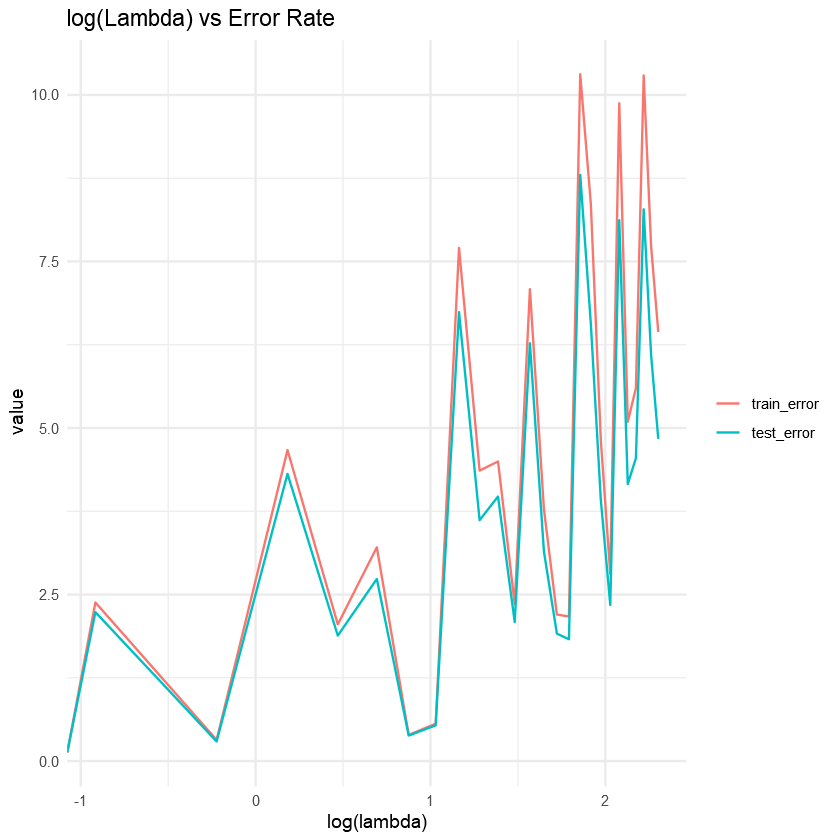

In [29]:
# playing with the SGD part
play_with_sgd()